In [3]:
import pandas as pd 
import sys
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import roc_auc_score, roc_curve
import scipy.stats as stats
import pickle
from scipy.stats import wilcoxon, spearmanr

sys.path.append("C:/Users/20182460/Documents/GitHub/THESIS/analysis_kather")
from kather_analysis_function import AUC_kather
from sklearn.linear_model import LinearRegression

In [8]:
output_dir_RMTLR = "C:/Users/20182460/Desktop/Master_thesis/Code/Outputs/FINAL RESULTS/CRC/multitask_lasso"
output_dir_MIL = "C:/Users/20182460/Desktop/Master_thesis/Code/Outputs/FINAL RESULTS/CRC/MIL/MIL_final_pcchip"

# Define the names of the files and corresponding variables
file_names = ["Pan-CK_99","E-cadherin_99", "cadpan_99", "CD3e_99", "CD31_99"]

loaded_data_RMTLR = {}
# Load the lists using a loop
for name in file_names:
    with open(f"{output_dir_RMTLR}/{name}.pkl", "rb") as file:
        loaded_data_RMTLR[name] = pickle.load(file)

loaded_data_MIL = {}
# Load the lists using a loop
for name in file_names:
    with open(f"{output_dir_MIL}/{name}.pkl", "rb") as file:
        loaded_data_MIL[name] = pickle.load(file)

In [5]:
panck_RMTLR = loaded_data_RMTLR['Pan-CK_99']['separate_corrs']
panck_MIL= loaded_data_MIL['Pan-CK_99']['separate_corrs']

Ecad_RMTLR = loaded_data_RMTLR['E-cadherin_99']['separate_corrs']
Ecad_MIL= loaded_data_MIL['E-cadherin_99']['separate_corrs']

CD3e_RMTLR = loaded_data_RMTLR['CD3e_99']['separate_corrs']
CD3e_MIL= loaded_data_MIL['CD3e_99']['separate_corrs']

CD31_RMTLR = loaded_data_RMTLR['CD31_99']['separate_corrs']
CD31_MIL= loaded_data_MIL['CD31_99']['separate_corrs']

Group: Pan-CK
Spearman's ρ: 0.503
p-value: 7.996e-04
Group: E-cadherin
Spearman's ρ: 0.132
p-value: 4.124e-01
Group: CD3e
Spearman's ρ: 0.372
p-value: 1.669e-02
Group: CD31
Spearman's ρ: 0.409
p-value: 7.976e-03


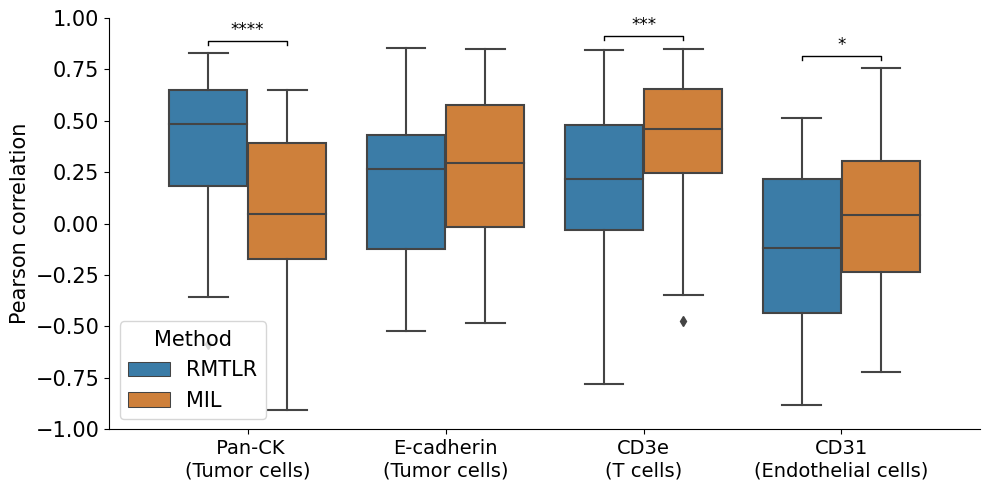

In [6]:
# Prepare data
all_data = []
output_dir_plot = "C:/Users/20182460/Desktop/Master_thesis/Figures report/figures_lasso_vs_MIL"

data_sources = [
    ("Pan-CK", "RMTLR", panck_RMTLR),
    ("Pan-CK", "MIL", panck_MIL),
    ("E-cadherin", "RMTLR", Ecad_RMTLR),
    ("E-cadherin", "MIL", Ecad_MIL),
    ("CD3e", "RMTLR", CD3e_RMTLR),
    ("CD3e", "MIL", CD3e_MIL),
    ("CD31", "RMTLR", CD31_RMTLR),
    ("CD31", "MIL", CD31_MIL)
]

for cell_type, method, scores_dict in data_sources:
    for slide_id, values in scores_dict.items():
        all_data.append([values[0], method, cell_type, slide_id])

# Convert to DataFrame
df = pd.DataFrame(all_data, columns=["Correlation", "Method", "Marker", "Slide_ID"])

group_pairs = [
    ("Pan-CK", panck_RMTLR, panck_MIL),
    ("E-cadherin", Ecad_RMTLR, Ecad_MIL),
    ("CD3e", CD3e_RMTLR, CD3e_MIL),
    ("CD31", CD31_RMTLR, CD31_MIL)
]

p_values = {}
group_max_values = {}

# Calculate p-values and group-wise maximums
for group, rmtlr_dict, mil_dict in group_pairs:
    common_keys = set(rmtlr_dict.keys()) & set(mil_dict.keys())
    rmtlr_values = [rmtlr_dict[k][0] for k in common_keys]
    mil_values = [mil_dict[k][0] for k in common_keys]
    
    if rmtlr_values and mil_values:
        _, p = wilcoxon(rmtlr_values, mil_values, alternative='two-sided')
        p_values[group] = p
        rho, p_corr = spearmanr(rmtlr_values, mil_values)
        print(f"Group: {group}\nSpearman's ρ: {rho:.3f}\np-value: {p_corr:.3e}")
        group_max_values[group] = max(rmtlr_values + mil_values)

# Set color palette
palette = {"RMTLR": "#2980b9", "MIL": "#e67e22"}

plt.figure(figsize=(10, 5))
sns.boxplot(x='Marker', y='Correlation', hue='Method', data=df, palette=palette)

# Add significance markers
for i, (group, p_value) in enumerate(p_values.items()):
    if p_value < 0.05:
        stars = "****" if p_value < 0.0001 else "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*"
        y_max_group = group_max_values[group]
        x1, x2 = i - 0.2, i + 0.2
        y = y_max_group + 0.05 * y_max_group
        plt.plot([x1, x1, x2, x2], [y, y + 0.02, y + 0.02, y], color="black", lw=1)
        plt.text((x1 + x2) / 2, y + 0.03, stars, ha='center', va='bottom', fontsize=12)

plt.ylabel("Pearson correlation", fontsize=15)
plt.xlabel("")
plt.xticks(ticks=[0, 1, 2, 3], labels=[" Pan-CK\n(Tumor cells)", "E-cadherin\n(Tumor cells)", "CD3e\n(T cells)", "CD31\n(Endothelial cells)"], fontsize=14)
plt.yticks(fontsize=15)
plt.legend(title="Method", fontsize=15, title_fontsize=15)
plt.ylim(-1, 1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(f"{output_dir_plot}/boxplot_Correlation_comparison.png", dpi=300)
plt.show()


In [55]:
# Function to perform Wilcoxon test
def perform_wilcoxon_test(dict_lasso, dict_MIL, label):
    # Extract paired values
    paired_values = [(dict_lasso[key][0], dict_MIL[key][0]) for key in dict_lasso.keys() if key in dict_MIL]
    lasso_values, MIL_values = zip(*paired_values)
    
    # Perform the Wilcoxon test
    stat, p_value = wilcoxon(lasso_values, MIL_values, alternative='two-sided')
    
    # Return the results
    print(f"{label}: Wilcoxon signed-rank test statistic={stat:.4f}, p-value={p_value:.4f}")
    return stat, p_value

# Perform Wilcoxon tests for correlation scores
print("Correlation Scores:")
stat_tumor_corr = perform_wilcoxon_test(IF_scores_lasso_tumor, IF_scores_MIL_tumor, "Spearman tumor")
stat_tumor_corr = perform_wilcoxon_test(IF_scores_lasso_T, IF_scores_MIL_T, "Spearman T")
stat_tumor_corr = perform_wilcoxon_test(IF_scores_lasso_endo, IF_scores_MIL_endo, "Spearman endo")

# Perform Wilcoxon tests for AUC
print("\nAUC Scores:")
paired_auc_values = [(AUC_tumor_lasso[key], AUC_tumor_MIL[key]) for key in AUC_tumor_lasso.keys() if key in AUC_tumor_MIL]
lasso_auc_values, MIL_auc_values = zip(*paired_auc_values)
stat_auc, p_value_auc = wilcoxon(lasso_auc_values, MIL_auc_values, alternative='two-sided')
print(f"AUC Tumor: Wilcoxon signed-rank test statistic={stat_auc:.4f}, p-value={p_value_auc:.4f}")

Correlation Scores:
Spearman tumor: Wilcoxon signed-rank test statistic=288.0000, p-value=0.0654
Spearman T: Wilcoxon signed-rank test statistic=368.0000, p-value=0.4257
Spearman endo: Wilcoxon signed-rank test statistic=140.0000, p-value=0.0001

AUC Scores:
AUC Tumor: Wilcoxon signed-rank test statistic=84.0000, p-value=0.0000
